# <mark>PyTorch:</mark> ConvNeXtTiny Implementation W/Imagewoof

In this notebook, we will explore the application of the ConvNetXTiny model for training the Imagewoof dataset. ConvNetXTiny is a lightweight convolutional neural network architecture designed for efficient image classification tasks. Imagenewoof, a variant of the Imagenette dataset, consists of images belonging to ten different dog breeds, presenting a challenging yet manageable dataset for training deep learning models.

In [28]:
# PyTorch Utils
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split
from torchvision.transforms import v2 as T
from torchvision import datasets
import torchvision.models as models
import torch.nn as nn

# MatPlot
import matplotlib.pyplot as plt

# NumPy
import numpy as np

# Pandas
import pandas as pd

In [2]:
# Debug CUDA information
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 1650


In [3]:
# Device usage definition
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

### Load Imagewoof Dataset

The images are 320x320, with pixel values ranging from 0 to 255. The labels are an array of strings, ranging from 0 to 9. These correspond to the class of clothing the image represents:

| <div style="width:300px">**Label**</div> |  <div style="width:300px">**Class**</div>  |
|:---------------|:---------------|
| n02086240      | Shih-Tzu |
| n02087394      | Rhodesian ridgeback |
| n02088364      | Beagle |
| n02089973      | English foxhound |
| n02093754      | Border terrier |
| n02096294      | Australian terrier |
| n02099601      | Golden retriever |
| n02105641      | Old English sheepdog |
| n02111889      | Samoyed |
| n02115641      | Dingo |

<br>

In [4]:
# Define the directory where your dataset is located
data_dir = 'Datasets/Imagewoof'

In [19]:
# Define the transformations you want to apply to the images
data_transforms = {
    'train': T.Compose([
        T.ToImage(), # Convert to tensor, because the image comes has PIL
        T.Resize(size=(224, 224)),
        T.RandomResizedCrop(size=(186, 186), antialias=True),
        T.RandomHorizontalFlip(),
        T.RandomGrayscale(p=0.2),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.ToImage(), # Convert to tensor, because the image comes has PIL
        T.Resize(size=(224, 224)),
        T.CenterCrop(224),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [20]:
# Create the training set
training_data = datasets.ImageFolder(f'{data_dir}/train', data_transforms['train'])
print("Training Set:", len(training_data))

# Create the validation set
val_data = datasets.ImageFolder(f'{data_dir}/val', data_transforms['val'])
print("Validation Set:", len(val_data))

Training Set: 9025
Validation Set: 3929


In [21]:
# Create data loader for the train set
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True, num_workers=4)
print(train_dataloader)

# Create data loader for the train see
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True, num_workers=4)
print(val_dataloader)

### Define New Classes With the Correct Dog Breeds

In [22]:
# Correct dog breeds
dog_breeds = [
    'Shih-Tzu', 'Rhodesian Ridgeback', 'Beagle', 'English Foxhound', 'Border Terrier',
    'Australian Terrier', 'Golden Retriever', 'Old English Sheepdog', 'Samoyed', 'Dingo'
]

# Assing the dog breeds to the labels_map
labels_map = dog_breeds

### Iterating and Visualising the Dataset

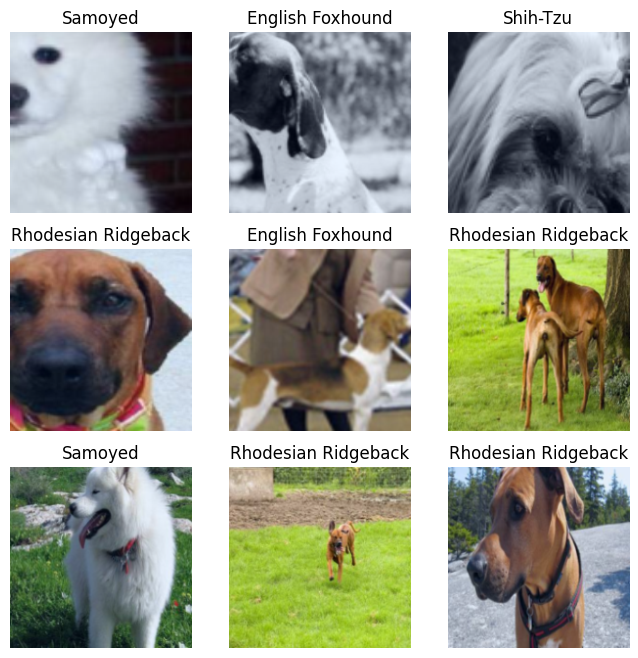

In [23]:
# Plot dimensions and configs
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]    
    img = (img - img.min()) / (img.max() - img.min())
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0))
plt.show()

### Create Test Set (Subset of 20% of the Validation Set)

In [24]:
# Define the size of the test dataset (e.g., 20% of the validation set)
test_size = int(0.2 * len(val_data))
val_size = len(val_data) - test_size

In [25]:
# Use random_split to split the validation dataset into validation and test datasets
val_data, test_data = random_split(val_data, [val_size, test_size])

In [26]:
# Create DataLoader objects for validation and test subsets
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4)

In [27]:
# Length of the training set
train_set_length = len(training_data)
print("Length of the train set:", train_set_length)

# Length of the validation set
validation_set_length = len(val_data)
print("Length of the validation set:", validation_set_length)

# Length of the test set
test_set_length = len(test_data)
print("Length of the test set:", test_set_length)

Length of the train set: 9025
Length of the validation set: 3144
Length of the test set: 785


### Training the Model

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'Model/best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualising the Model Predictions

In [32]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the ConvNeXtTiny

In [33]:
model_ft = models.convnext_tiny(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(labels_map))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

AttributeError: 'ConvNeXt' object has no attribute 'fc'

In [30]:
# Instantiate the model
model = ConvNeXtTiny(num_classes=len(labels_map))

/home/joseareia/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/joseareia/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /home/joseareia/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109M/109M [00:58<00:00, 1.95MB/s]


AttributeError: 'ConvNeXt' object has no attribute 'fc'